# Artificial dataset generation

In [1]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2019_02_21', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports

In [ ]:
# Standard lib imports
import os
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

# Nanocompore simulator
from nanocompore.SimReads import SimReads

## Generate reads

### Test on single ref + plot

Initialising SimReads and checking options
Writing log file
Importing RNA model file
Reading Fasta file and simulate corresponding data
Processing reference ref_0001
	Try to find 28 kmers to modify
	Found valid combination for 28 kmers
	modified positions: [  5  15  23  33  46  74  81 107 117 124 134 158 168 185 194 211 268 288
 300 319 348 362 384 396 405 416 463 495]


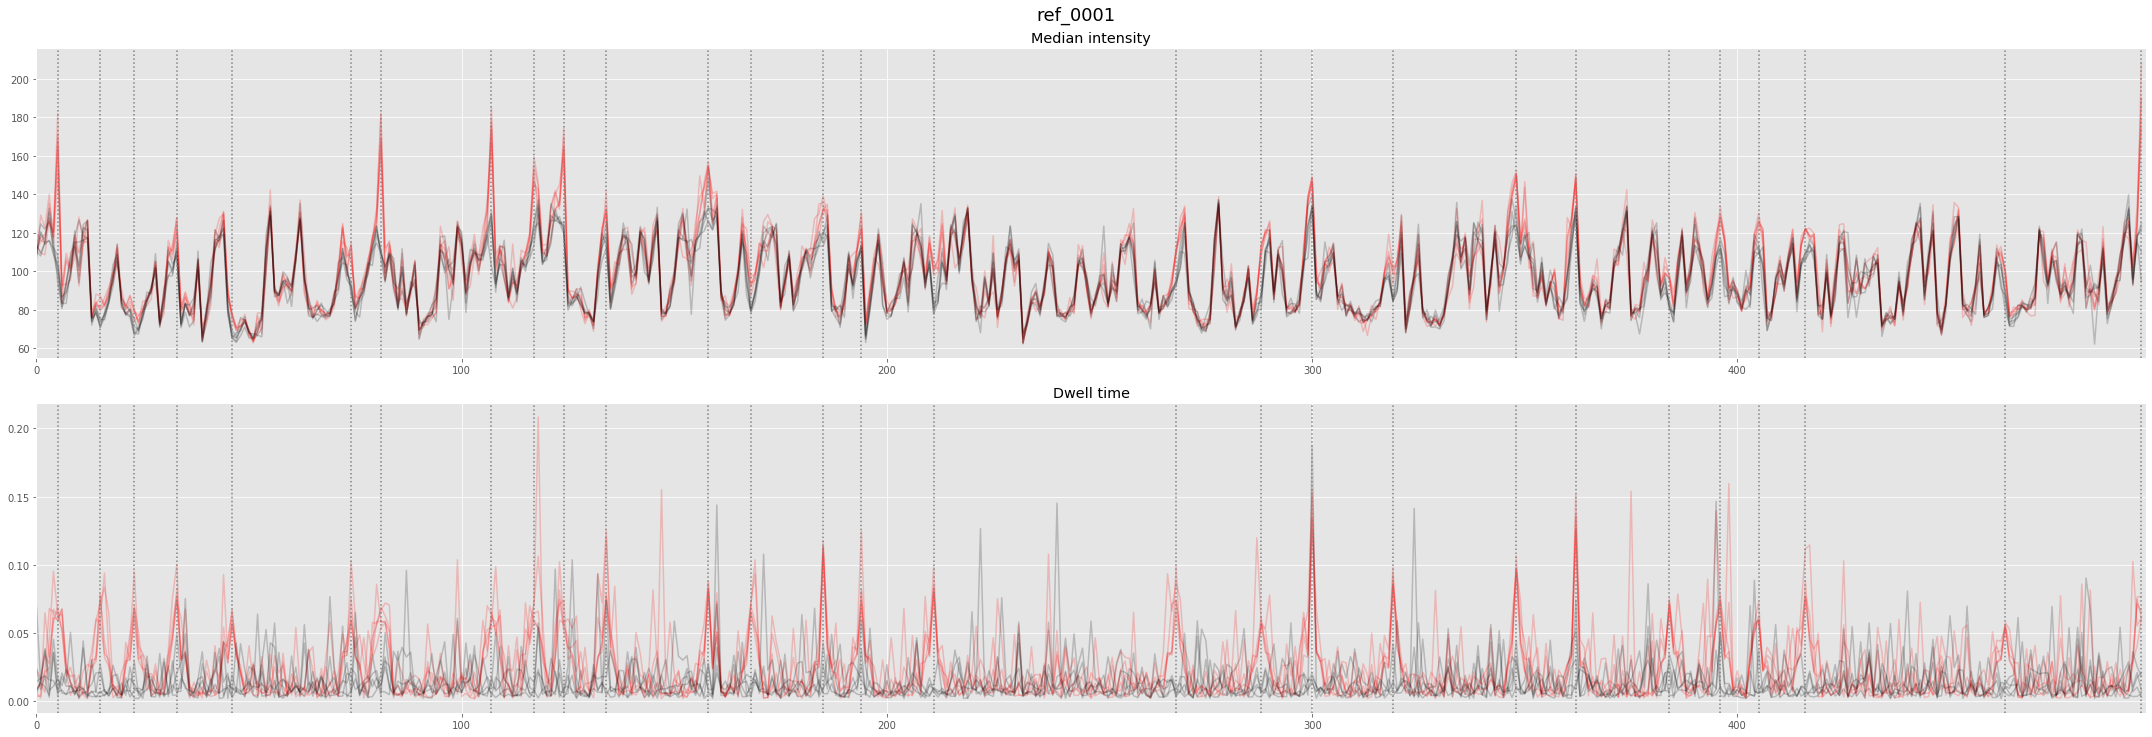

In [4]:
SimReads (
    fasta_fn="data/references/random_guided_weight.fa", 
    outpath="data/artificial_datasets/", 
    ref_list=["ref_0001"], 
    log_level="debug", 
    plot=True,
    nreads_per_ref=10,
    mod_reads_freq=0.5, 
    mod_bases_freq=0.20, 
    intensity_mod=5, 
    dwell_mod=5, 
    mod_extend_context=2,
    pos_rand_seed=2
    )

### Generate all read datasets

In [24]:
# Options
fasta = "data/references/random_guided_weight.fa"
nreads_per_ref = 100
mod_bases_freq = 0.25
mod_bases_type = "A"
mod_extend_context = 2
min_mod_dist = 6
pos_rand_seed = 2
log_level = "warning"
dwell_mod_list = [0, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5]
intensity_mod_list = [0, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5]
mod_reads_freq_list = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

# Create directory for results
data_dir = "data/simulated_datasets/"
rmtree (data_dir, ignore_errors=True)
mkdir (data_dir)

# Generate datasets
index_fn = os.path.join(data_dir, "index.tsv")
i = 0
with open (index_fn, "w") as fp:
    fp.write("\t".join(["dataset_id","intensity_mod","dwell_mod","mod_reads_freq"]) + "\n")
    
    # Generate all the possible combinations
    for mod_reads_freq in mod_reads_freq_list:
        for intensity_mod in intensity_mod_list:
            for dwell_mod in dwell_mod_list:
                
                # The only condition were mod_reads_freq should be 0 is when both intensity and dwell_mod are also 0 => Null control
                if not mod_reads_freq and (intensity_mod+dwell_mod>0):
                    print (f"Eliminate condition: mod_reads_freq={mod_reads_freq} intensity_mod={intensity_mod} dwell_mod={dwell_mod}")
                    continue
                # Also eliminate conditions where both intensity and dwell loc are zero as it would be the same as the null control
                if mod_reads_freq and (intensity_mod+dwell_mod==0):
                    print (f"Eliminate condition: mod_reads_freq={mod_reads_freq} intensity_mod={intensity_mod} dwell_mod={dwell_mod}")
                    continue
                    
                i+=1
                dataset_id = "dataset_{:04}".format(i)
                fp.write(f"{dataset_id}\t{intensity_mod}\t{dwell_mod}\t{mod_reads_freq}\n")
                outpath = os.path.join(data_dir, dataset_id)
                
                # Generate 2 replicates with different distribution random seeds
                for replicate in [1,2]: 
                    # Build and run bash command through bsub
                    cmd = f"nanocompore simreads\
                        --fasta {fasta}\
                        --outpath {outpath}\
                        --outprefix reads_{replicate}\
                        --overwrite\
                        --nreads_per_ref {nreads_per_ref}\
                        --intensity_mod {intensity_mod}\
                        --dwell_mod {dwell_mod}\
                        --mod_reads_freq {mod_reads_freq}\
                        --mod_bases_freq {mod_bases_freq}\
                        --mod_bases_type {mod_bases_type}\
                        --mod_extend_context {mod_extend_context}\
                        --min_mod_dist {min_mod_dist}\
                        --pos_rand_seed {pos_rand_seed}\
                        --log_level {log_level}"
                    cmd = ' '.join(cmd.split())
                    bsub (virtualenv="nanocompore", cmd=cmd, dry=False, threads=4, mem=2000, print_cmd=True)

df = pd.read_csv(index_fn, sep="\t")
with pd.option_context("display.max_rows", 10):
    display (df)

Creating /nfs/leia/research/enright/nanopore/analyses/nanocompore_paper_analyses/in_silico_dataset/data/simulated_datasets
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0001 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0 --mod_reads_freq 0.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927906> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0001 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0 --mod_reads_freq 0.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927907> is submitted to default queue <standard

Job <6927908> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0002 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0.2 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927909> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0003 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0.4 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927910> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6927956> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0012 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0.2 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927957> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0012 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0.2 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927958> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6927993> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0021 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927994> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0022 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0.2 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6927995> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928036> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0031 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 0 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928037> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0031 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 0 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928038> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6928078> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0040 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 5 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928080> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0041 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 0 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928081> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6928117> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0050 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 5 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928118> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0050 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 5 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928119> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6928150> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0059 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 4 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928154> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0060 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 5 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928155> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6928178> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0069 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 4 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928179> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0069 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 4 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928180> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6928202> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0078 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 3 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928207> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0079 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 4 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928208> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6928235> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0088 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 3 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928236> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0088 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 3 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928237> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6928269> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0097 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 2 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928270> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0098 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 3 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928275> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6928308> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0107 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 3 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928309> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0107 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 3 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928311> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6928346> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0116 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 2 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928347> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0117 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 3 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928348> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928383> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0126 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 2 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928384> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0126 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 2 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928392> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928423> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0135 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 1 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928424> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0136 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 2 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928425> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928469> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0145 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 1 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928471> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0145 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 1 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928472> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928503> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0154 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 0.8 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928504> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0155 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 1 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928510> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6928551> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0164 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 0.8 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928552> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0164 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 0.8 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928553> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928595> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0173 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 0.6 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928596> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0174 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 0.8 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928597> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928647> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0183 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 0.6 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928648> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0183 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 0.6 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928649> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928668> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0192 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 0.4 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928669> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0193 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 0.6 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928689> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6928711> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0202 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0.6 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928712> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0202 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0.6 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928733> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6928757> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0211 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0.4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928758> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0212 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0.6 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928759> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6928814> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0221 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0.4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928815> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0221 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0.4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928818> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6928847> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0230 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 0.2 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928848> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0231 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 0.4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928849> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6928871> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0240 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 0.2 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928878> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0240 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 0.2 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928879> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6928920> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0249 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 0 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928922> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0250 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 0.2 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928923> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6928962> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0259 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 0 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928963> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0259 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 0 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6928964> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6929011> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0268 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 5 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929012> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0269 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 0 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929013> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6929046> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0278 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 5 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929047> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0278 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 5 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929049> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6929081> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0287 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929082> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0288 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 5 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929083> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6929119> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0297 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929120> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0297 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 4 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929121> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6929174> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0306 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 4 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929175> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0307 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 5 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929176> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6929213> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0316 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 4 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929214> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0316 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 4 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929215> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6929257> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0325 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 3 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929258> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0326 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 4 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929259> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6929293> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0335 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 3 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929294> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0335 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 3 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929295> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6929333> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0344 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 2 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929334> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0345 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 3 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929335> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6929378> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0354 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 2 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929379> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0354 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 2 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929380> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6929413> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0363 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 1 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929414> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0364 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 2 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929415> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6929460> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0373 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 1 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929461> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0373 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 1 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929462> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6929493> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0382 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 0.8 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929494> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0383 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 1 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929495> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6929532> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0392 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 0.8 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929533> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0392 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 0.8 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929534> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simr

Job <6929563> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0401 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0.8 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929564> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0402 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 1 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929565> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6929595> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0411 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0.8 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929596> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0411 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0.8 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929597> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6929624> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0420 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0.6 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929625> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0421 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0.8 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929626> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6929656> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0430 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 0.6 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929657> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0430 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 0.6 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929664> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6929686> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0439 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 0.4 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929687> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0440 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 0.6 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929688> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore si

Job <6929722> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0449 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 0.4 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929723> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0449 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 0.4 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929724> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6929758> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0458 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 0.2 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929759> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0459 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 0.4 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929760> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6929789> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0468 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 0.2 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929790> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0468 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 0.2 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929794> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6929821> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0477 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 0 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929824> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0478 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 0.2 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929825> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads

Job <6929854> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0487 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 0 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929855> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0487 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 0 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929856> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6929889> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0496 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 5 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929890> is submitted to default queue <standard>.
Eliminate condition: mod_reads_freq=1.0 intensity_mod=0 dwell_mod=0
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0497 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0 --dwell_mod 0.2 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929893> is submitted to default queue <stand

Job <6929932> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0506 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929936> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0506 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 0 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929937> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6929969> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0515 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.2 --dwell_mod 5 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929970> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0516 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 0 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6929971> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6930008> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0525 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 5 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930009> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0525 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.4 --dwell_mod 5 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930010> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6930045> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0534 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 4 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930046> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0535 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.6 --dwell_mod 5 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930047> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6930077> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0544 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 4 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930080> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0544 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 0.8 --dwell_mod 4 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930081> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simrea

Job <6930119> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0553 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 3 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930120> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0554 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 1 --dwell_mod 4 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930121> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6930143> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0563 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 3 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930145> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0563 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 2 --dwell_mod 3 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930150> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6930181> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0572 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 2 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930182> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0573 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 3 --dwell_mod 3 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930183> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6930216> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0582 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 2 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930217> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0582 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 4 --dwell_mod 2 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930218> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

Job <6930254> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0591 --outprefix reads_2 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 1 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930257> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads --fasta data/references/random_guided_weight.fa --outpath data/simulated_datasets/dataset_0592 --outprefix reads_1 --overwrite --nreads_per_ref 100 --intensity_mod 5 --dwell_mod 2 --mod_reads_freq 1.0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 2 --min_mod_dist 6 --pos_rand_seed 2 --log_level warning"
Job <6930258> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 4  "nanocompore simreads -

,dataset_id,intensity_mod,dwell_mod,mod_reads_freq
0,dataset_0001,0.0,0.0,0.0
1,dataset_0002,0.0,0.2,0.1
2,dataset_0003,0.0,0.4,0.1
3,dataset_0004,0.0,0.6,0.1
4,dataset_0005,0.0,0.8,0.1
...,...,...,...,...
590,dataset_0591,5.0,1.0,1.0
591,dataset_0592,5.0,2.0,1.0
592,dataset_0593,5.0,3.0,1.0
593,dataset_0594,5.0,4.0,1.0
